## Logistic Regression Model Using Lumbar Coordinate Metadata

This project trains and evaluates a **multiclass Logistic Regression model** using exclusively the metadata provided in the `coords_rsna_improved.csv` file from the *Lumbar Coordinate Pretraining Dataset* by Brendan Artley (Kaggle).

The notebook focuses on working **only with structured CSV data**, without requiring the associated medical images. The dataset contains coordinate annotations (e.g., `relative_x`, `relative_y`), instance and study identifiers, anatomical levels, laterality information, and diagnostic labels describing different types of spinal canal or foraminal narrowing.

### Objectives

- Load and preprocess the CSV file (handle missing values, select relevant features).
- Encode categorical and numerical features through a clean preprocessing pipeline.
- Train a **multinomial Logistic Regression classifier** to predict the `condition` label.
- Apply a stratified 70/15/15 train–validation–test split to preserve class distribution.
- Address class imbalance via `class_weight='balanced'`.
- Evaluate the model using:
  - Accuracy on validation and test sets  
  - Per-class precision, recall, and F1-score  
  - Confusion matrix  

### Why Logistic Regression?

Although more complex models (CNNs, transformers, etc.) can be applied to medical imaging tasks, Logistic Regression provides:

- A transparent, interpretable baseline  
- A fast training cycle  
- A good reference point for future comparison with deep learning approaches  
- A way to assess how much predictive power comes from metadata alone  

### Dataset Notes

- The dataset includes **five medical diagnostic categories** related to lumbar spine pathology.
- The CSV includes both **numeric features** (relative coordinates, instance number) and **categorical features** (side, spine level).
- These features allow building a structured ML model without accessing DICOM or JPG images.
- Labels are moderately imbalanced; therefore, class-weighting is used during training.

### Deliverables

This notebook will produce:
- A fully trained Logistic Regression pipeline  
- Metrics and evaluation plots  
- A reusable `.joblib` model (optional)  
- A reproducible workflow suitable for experimentation or baseline benchmarking  

## Files & Variables
**train.csv** Labels for the train set.

* <mark>study_id</mark> - The study ID. Each study may include multiple series of images.
* <mark>[condition]_[level]</mark> - The target labels, such as spinal_canal_stenosis_l1_l2, with the severity levels of Normal/Mild, Moderate, or Severe. Some entries have incomplete labels.

**train_label_coordinates.csv**

* <mark>study_id</mark>
* <mark>series_id</mark> - The imagery series ID.
* <mark>instance_number</mark> - The image's order number within the 3D stack.
* <mark>condition</mark> - There are three core conditions: spinal canal stenosis, neural_foraminal_narrowing, and subarticular_stenosis. The latter two are considered for each side of the spine.
* <mark>level</mark> - The relevant vertebrae, such as l3_l4
* <mark>[x/y]</mark> - The x/y coordinates for the center of the area that defined the label.

**sample_submission.csv**

* <mark>row_id</mark> - A slug of the study ID, condition, and level such as 12345_spinal_canal_stenosis_l3_l4.
* <mark>[normal_mild/moderate/severe]</mark> - The three prediction columns.

**[train/test]_images/[study_id]/[series_id]/[instance_number].dcm** The imagery data.

**[train/test]_series_descriptions.csv**

* <mark>study_id</mark>
* <mark>series_id</mark>
* <mark>series_description</mark> The scan's orientation.

In [1]:
# Imports (comments in English)
import os
import numpy as np
import pandas as pd
import cv2
import pydicom
import glob
from tqdm import tqdm
import json
import warnings
import dicom2jpg

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Optional plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import kagglehub
import shutil
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "rsna-2024-lumbar-spine-degenerative-classification"
DATA_DIR.mkdir(parents=True, exist_ok=True)
print(DATA_DIR)



KAG_CSV_CANDIDATES = ["sample_submission.csv", "test_series_descriptions.csv", "train.csv","train_label_coordinates.csv","train_series_descriptions.csv"]


C:\Users\mmich\Documentos\Maestría en Sistemas Computacionales\3er Semestre\Aprendizaje Automatico\iteso ML\iteso_class\data\raw\rsna-2024-lumbar-spine-degenerative-classification


In [2]:

# Desktop path
SAMPLE_SUBMISSION = DATA_DIR / KAG_CSV_CANDIDATES[0]
TEST_SERIES_DESCRIPTIONS = DATA_DIR / KAG_CSV_CANDIDATES[1]
TRAIN = DATA_DIR / KAG_CSV_CANDIDATES[2]
TRAIN_LABEL_COORDINATES = DATA_DIR / KAG_CSV_CANDIDATES[3]
TRAIN_SERIES_DESCRIPTIONS = DATA_DIR / KAG_CSV_CANDIDATES[4]

df_train = pd.read_csv(TRAIN)
df_coor = pd.read_csv(TRAIN_LABEL_COORDINATES)
df_meta_f  = pd.read_csv(TRAIN_SERIES_DESCRIPTIONS)


In [3]:
print("[INFO] Columns:", list(df_train.columns))
display(df_train[df_train["study_id" ]== 4003253])
display(f"rows: ", len(df_train))
#display(df_train.info())
#display(df_train)
print("\nMissing Values (%):")
missing_pct = (df_train.isnull().mean() * 100).round(2)
print(missing_pct)


[INFO] Columns: ['study_id', 'spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4', 'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1', 'left_neural_foraminal_narrowing_l1_l2', 'left_neural_foraminal_narrowing_l2_l3', 'left_neural_foraminal_narrowing_l3_l4', 'left_neural_foraminal_narrowing_l4_l5', 'left_neural_foraminal_narrowing_l5_s1', 'right_neural_foraminal_narrowing_l1_l2', 'right_neural_foraminal_narrowing_l2_l3', 'right_neural_foraminal_narrowing_l3_l4', 'right_neural_foraminal_narrowing_l4_l5', 'right_neural_foraminal_narrowing_l5_s1', 'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3', 'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5', 'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2', 'right_subarticular_stenosis_l2_l3', 'right_subarticular_stenosis_l3_l4', 'right_subarticular_stenosis_l4_l5', 'right_subarticular_stenosis_l5_s1']


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild


'rows: '

1975


Missing Values (%):
study_id                                  0.00
spinal_canal_stenosis_l1_l2               0.05
spinal_canal_stenosis_l2_l3               0.05
spinal_canal_stenosis_l3_l4               0.05
spinal_canal_stenosis_l4_l5               0.05
spinal_canal_stenosis_l5_s1               0.05
left_neural_foraminal_narrowing_l1_l2     0.10
left_neural_foraminal_narrowing_l2_l3     0.10
left_neural_foraminal_narrowing_l3_l4     0.10
left_neural_foraminal_narrowing_l4_l5     0.10
left_neural_foraminal_narrowing_l5_s1     0.10
right_neural_foraminal_narrowing_l1_l2    0.41
right_neural_foraminal_narrowing_l2_l3    0.41
right_neural_foraminal_narrowing_l3_l4    0.41
right_neural_foraminal_narrowing_l4_l5    0.41
right_neural_foraminal_narrowing_l5_s1    0.41
left_subarticular_stenosis_l1_l2          8.30
left_subarticular_stenosis_l2_l3          4.15
left_subarticular_stenosis_l3_l4          0.15
left_subarticular_stenosis_l4_l5          0.15
left_subarticular_stenosis_l5_s1       

In [4]:
print("[INFO] Columns:", list(df_coor.columns))
display(df_coor)

df_coor[df_coor["study_id" ]== 4003253]


[INFO] Columns: ['study_id', 'series_id', 'instance_number', 'condition', 'level', 'x', 'y']


,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333


,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
5,4003253,1054713880,4,Right Neural Foraminal Narrowing,L4/L5,187.961759,251.839388
6,4003253,1054713880,4,Right Neural Foraminal Narrowing,L5/S1,198.240918,285.613767
7,4003253,1054713880,5,Right Neural Foraminal Narrowing,L3/L4,187.227533,210.722753
8,4003253,1054713880,6,Right Neural Foraminal Narrowing,L1/L2,194.569790,127.755258
9,4003253,1054713880,6,Right Neural Foraminal Narrowing,L2/L3,191.632887,165.934990


In [5]:
print("[INFO] Columns:", list(df_meta_f .columns))
display(df_meta_f )
display(df_meta_f[df_meta_f["study_id" ]== 4003253])


[INFO] Columns: ['study_id', 'series_id', 'series_description']


,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1
...,...,...,...
6289,4287160193,1507070277,Sagittal T2/STIR
6290,4287160193,1820446240,Axial T2
6291,4290709089,3274612423,Sagittal T2/STIR
6292,4290709089,3390218084,Axial T2


,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2


In [6]:
def build_label_col(row):
    cond = row["condition"].lower().replace(" ", "_")
    lvl = row["level"].lower().replace("/", "_")

    # neural foraminal + side appended (row may contain left/right)
    if cond == "neural_foraminal_narrowing" and "side" in row:
        return f"{cond}_{row['side'].lower()}_{lvl}"

    return f"{cond}_{lvl}"

def make_image_path(row):
    return str(
        DATA_DIR / "train_images" /
        str(row["study_id"]) /
        str(row["series_id"]) /
        f"{int(row['instance_number'])}.dcm"
    )

def dcm_to_matrix(dcm_path):
    dcm = pydicom.dcmread(dcm_path)
    arr = dcm.pixel_array

    # Normalize 0–255 uint8
    arr = cv2.normalize(arr, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")

    return arr  # numpy array


def resize_matrix_cv2(mat, target_size=(512, 512)):
    mat = np.asarray(mat)
    width, height = target_size[1], target_size[0]
    return cv2.resize(mat, (width, height), interpolation=cv2.INTER_AREA)


def apply_resize_cv2(df, col_matrix="matrix", new_col="matrix_512", size=(512, 512)):
    df[new_col] = df[col_matrix].apply(lambda m: resize_matrix_cv2(m, size))
    return df

def normalize_coords(row):
    H, W = row["matrix_shape"]
    x = row["x"]
    y = row["y"]
    
    return pd.Series({
        "x_norm": x / W,
        "y_norm": y / H
    })

In [7]:
df_coor["label_col"] = df_coor.apply(build_label_col, axis=1)

df_merged = df_coor.merge(
    df_train.set_index("study_id"),
    left_on="study_id",
    right_index=True,
    how="left"
)

df_merged = df_merged.merge(
    df_meta_f[["series_id","series_description"]],
    on="series_id",
    how="left"
)

df_merged["severity"] = df_merged.apply(
    lambda r: r[r["label_col"]] if r["label_col"] in df_train.columns else None,
    axis=1
)

df_merged["image_path"] = df_merged.apply(make_image_path, axis=1)

cols_to_drop = [
    c for c in df_merged.columns
    if c.startswith("spinal_canal_stenosis")
    or c.startswith("left_neural_foraminal_narrowing")
    or c.startswith("right_neural_foraminal_narrowing")
    or c.startswith("left_subarticular_stenosis")
    or c.startswith("right_subarticular_stenosis")
    or c == "label_col"
]

df_clean = df_merged.drop(columns=cols_to_drop)

display(df_clean[df_clean["study_id" ]== 4003253])

,study_id,series_id,instance_number,condition,level,x,y,series_description,severity,image_path
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Sagittal T2/STIR,Normal/Mild,C:\Users\mmich\Documentos\Maestría en Sistemas...
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Sagittal T2/STIR,Normal/Mild,C:\Users\mmich\Documentos\Maestría en Sistemas...
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Sagittal T2/STIR,Normal/Mild,C:\Users\mmich\Documentos\Maestría en Sistemas...
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Sagittal T2/STIR,Normal/Mild,C:\Users\mmich\Documentos\Maestría en Sistemas...
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Sagittal T2/STIR,Normal/Mild,C:\Users\mmich\Documentos\Maestría en Sistemas...
5,4003253,1054713880,4,Right Neural Foraminal Narrowing,L4/L5,187.961759,251.839388,Sagittal T1,Moderate,C:\Users\mmich\Documentos\Maestría en Sistemas...
6,4003253,1054713880,4,Right Neural Foraminal Narrowing,L5/S1,198.240918,285.613767,Sagittal T1,Normal/Mild,C:\Users\mmich\Documentos\Maestría en Sistemas...
7,4003253,1054713880,5,Right Neural Foraminal Narrowing,L3/L4,187.227533,210.722753,Sagittal T1,Moderate,C:\Users\mmich\Documentos\Maestría en Sistemas...
8,4003253,1054713880,6,Right Neural Foraminal Narrowing,L1/L2,194.569790,127.755258,Sagittal T1,Normal/Mild,C:\Users\mmich\Documentos\Maestría en Sistemas...
9,4003253,1054713880,6,Right Neural Foraminal Narrowing,L2/L3,191.632887,165.934990,Sagittal T1,Normal/Mild,C:\Users\mmich\Documentos\Maestría en Sistemas...


In [8]:
df_clean["pixel_matrix"] = df_clean["image_path"].apply(dcm_to_matrix)

In [9]:
df_clean["matrix_shape"] = df_clean["pixel_matrix"].apply(lambda m: m.shape)
df_clean[["relative_x", "relative_y"]] = df_clean.apply(normalize_coords, axis=1)
df_clean = df_clean.drop(columns=["image_path"])



In [10]:
df_clean["matrix_shape"].value_counts()

matrix_shape
(512, 512)    15037
(320, 320)    10611
(384, 384)     6579
(640, 640)     4014
(448, 448)     2953
              ...  
(552, 640)        4
(776, 704)        4
(544, 544)        4
(820, 704)        4
(240, 320)        1
Name: count, Length: 119, dtype: int64

In [11]:
df_clean = apply_resize_cv2(df_clean, col_matrix="pixel_matrix", new_col="matrix", size=(512, 512))

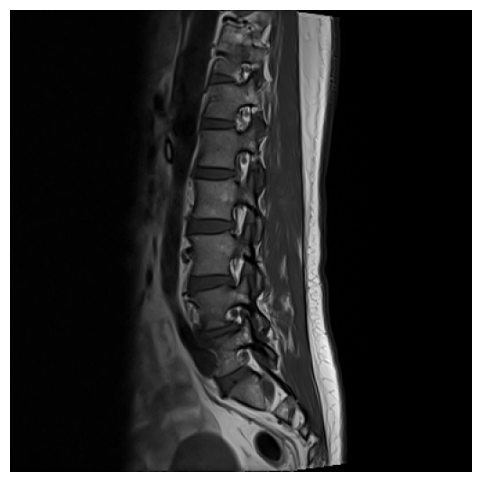

In [12]:
idx = 10
row = df_clean.iloc[idx]

img = row["matrix"]

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [13]:
df_clean.drop(columns=["matrix_shape"],inplace=True)
df_clean.drop(columns=["pixel_matrix"],inplace=True)
df_clean.drop(columns=["x"],inplace=True)
df_clean.drop(columns=["y"],inplace=True)
df_clean.drop(columns=["study_id"],inplace=True)
df_clean.drop(columns=["series_id"],inplace=True)
df_clean.drop(columns=["instance_number"],inplace=True)

In [14]:
pd.reset_option("all")
df_clean


C:\Users\mmich\AppData\Local\Temp\ipykernel_28636\3881939008.py:1: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option("all")
C:\Users\mmich\AppData\Local\Temp\ipykernel_28636\3881939008.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option("all")


,condition,level,series_description,severity,relative_x,relative_y,matrix
0,Spinal Canal Stenosis,L1/L2,Sagittal T2/STIR,Normal/Mild,0.504425,0.356195,"[[2, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 2, 3, 3, 3,..."
1,Spinal Canal Stenosis,L2/L3,Sagittal T2/STIR,Normal/Mild,0.500893,0.462054,"[[2, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 2, 3, 3, 3,..."
2,Spinal Canal Stenosis,L3/L4,Sagittal T2/STIR,Normal/Mild,0.504735,0.580966,"[[2, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 2, 3, 3, 3,..."
3,Spinal Canal Stenosis,L4/L5,Sagittal T2/STIR,Normal/Mild,0.523894,0.667699,"[[2, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 2, 3, 3, 3,..."
4,Spinal Canal Stenosis,L5/S1,Sagittal T2/STIR,Normal/Mild,0.552212,0.756195,"[[2, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 2, 3, 3, 3,..."
...,...,...,...,...,...,...,...
48687,Left Neural Foraminal Narrowing,L1/L2,Sagittal T1,Normal/Mild,0.571526,0.254768,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
48688,Left Neural Foraminal Narrowing,L2/L3,Sagittal T1,Normal/Mild,0.534741,0.365123,"[[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
48689,Left Neural Foraminal Narrowing,L3/L4,Sagittal T1,Normal/Mild,0.527929,0.471390,"[[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
48690,Left Neural Foraminal Narrowing,L4/L5,Sagittal T1,Normal/Mild,0.528472,0.572222,"[[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [15]:
df = df_clean.dropna(subset=["severity"]).reset_index(drop=True)
df["severity"].value_counts()

df = df[df["relative_x"] >= 0.1].reset_index(drop=True)


In [16]:
del df_clean


In [17]:
df["series_description"].value_counts()

series_description
Sagittal T1         19694
Axial T2            19215
Sagittal T2/STIR     9735
Name: count, dtype: int64

In [18]:
df_Axial = df[df["series_description"] == "Axial T2"]
df_SagiT1 = df[df["series_description"] == "Sagittal T1"]
df_SagiT2 = df[df["series_description"] == "Sagittal T2/STIR"]
df_list = [df_Axial, df_SagiT1, df_SagiT2]
del df 

In [19]:
df_Axial

,condition,level,series_description,severity,relative_x,relative_y,matrix
15,Left Subarticular Stenosis,L1/L2,Axial T2,Normal/Mild,0.559770,0.503861,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
16,Right Subarticular Stenosis,L1/L2,Axial T2,Normal/Mild,0.454027,0.495702,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
17,Left Subarticular Stenosis,L2/L3,Axial T2,Normal/Mild,0.565562,0.496139,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
18,Right Subarticular Stenosis,L2/L3,Axial T2,Normal/Mild,0.455938,0.490926,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
19,Left Subarticular Stenosis,L3/L4,Axial T2,Normal/Mild,0.550118,0.492278,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...
48629,Right Subarticular Stenosis,L3/L4,Axial T2,Normal/Mild,0.473244,0.556726,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
48630,Left Subarticular Stenosis,L4/L5,Axial T2,Normal/Mild,0.544068,0.533390,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
48631,Right Subarticular Stenosis,L4/L5,Axial T2,Normal/Mild,0.477728,0.532063,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
48632,Left Subarticular Stenosis,L5/S1,Axial T2,Normal/Mild,0.555903,0.576500,"[[0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,..."


In [20]:
from sklearn.decomposition import IncrementalPCA

def run_pca_and_save(X, n_components, batch_size=2048,name_series="Axial"):
    ipca = IncrementalPCA(n_components=n_components)

    # ---- PARTIAL FIT LOOP ----
    for start in range(0, X.shape[0], batch_size):
        end = start + batch_size
        batch = X[start:end, :]       # <-- FIX: slice NumPy array
        ipca.partial_fit(batch)

    # ---- TRANSFORM LOOP ----
    transformed_list = []
    for start in range(0, X.shape[0], batch_size):
        end = start + batch_size
        batch = X[start:end, :]
        transformed_list.append(ipca.transform(batch))

    transformed = np.vstack(transformed_list)

    # ---- SAVE PCA RESULTS ----
    df_pca = pd.DataFrame(transformed)
    df_pca.to_csv(PROJECT_ROOT / "data" / "processed" / f"pca_{n_components}_{name_series}.csv", index=False)

    # ---- SAVE VARIANCE ----
    variance_df = pd.DataFrame({
        "component": range(1, n_components + 1),
        "explained_variance": ipca.explained_variance_ratio_
    })
    variance_df.to_csv(PROJECT_ROOT / "data" / "processed" / f"pca_{n_components}_variance_{name_series}.csv", index=False)

    print(f"Saved PCA and variance for {n_components} components.")

In [21]:
def crop_square(img, x, y, S):
    img_size = img.shape[0]
    half = S // 2
    
    x = int(x * img_size)
    y = int(y * img_size)


    y1 = max(0, y - half)
    y2 = min(img.shape[0], y + half)
    
    x1 = max(0, x - half)
    x2 = min(img.shape[1], x + half)

    return img[y1:y2, x1:x2]

In [22]:
S = 320 # crop size
for m in df_list:
    m = apply_resize_cv2(m, col_matrix="matrix", new_col="matrix", size=(1024, 1024))
    m["crop"] = m.apply(
        lambda row: crop_square(
            row["matrix"],
            row["relative_x"],
            row["relative_y"],
            S
        ),
        axis=1
    )
    m.drop(columns=["matrix"],inplace=True)

In [23]:
for m in df_list:
    m = apply_resize_cv2(m, col_matrix="crop", new_col="matrix", size=(128, 128))
    m.drop(columns=["crop"],inplace=True)
    m.drop(columns=["relative_x","relative_y"],inplace=True)

In [24]:
curr_df = df_SagiT1
ids = curr_df.index.tolist()
len(ids)

19694

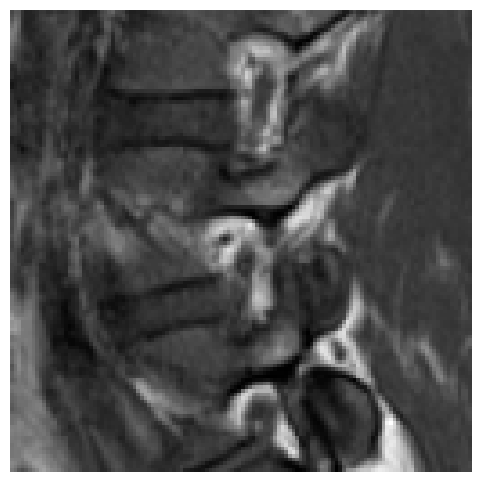

In [ ]:
curr_id = ids[5453]
curr_img = curr_df["matrix"][curr_id]

img = curr_img

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [35]:
PCA_elements = [2,4,8,16,32,64,128,256,512]
name_extension = ["Axial", "SagitalT1", "SagitalT2"]
for i,m in enumerate(df_list):
    m["flat"] = m["matrix"].apply(lambda m: m.flatten())
    flat = np.stack(m["flat"].values)
    for n in PCA_elements:
        run_pca_and_save(flat, n_components=n,name_series=name_extension[i])
    m.drop(columns=["flat"],inplace=True)


folders = ["512 Axial", "512 SagitalT1", "512 SagitalT2"]



KeyboardInterrupt: 

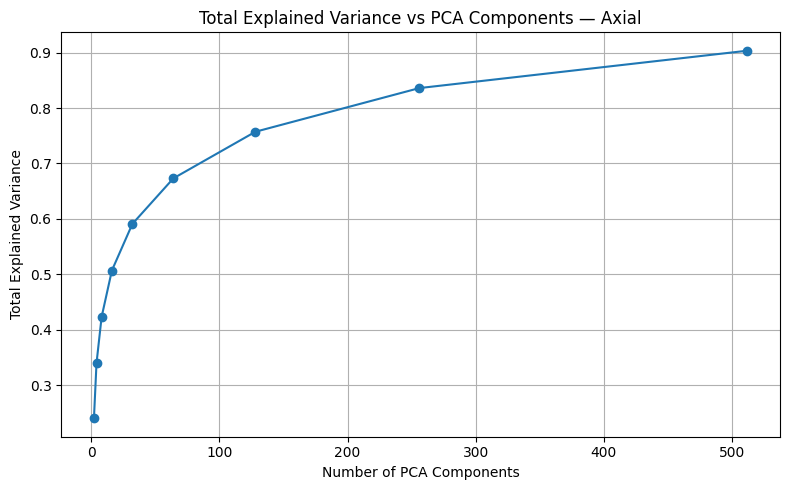

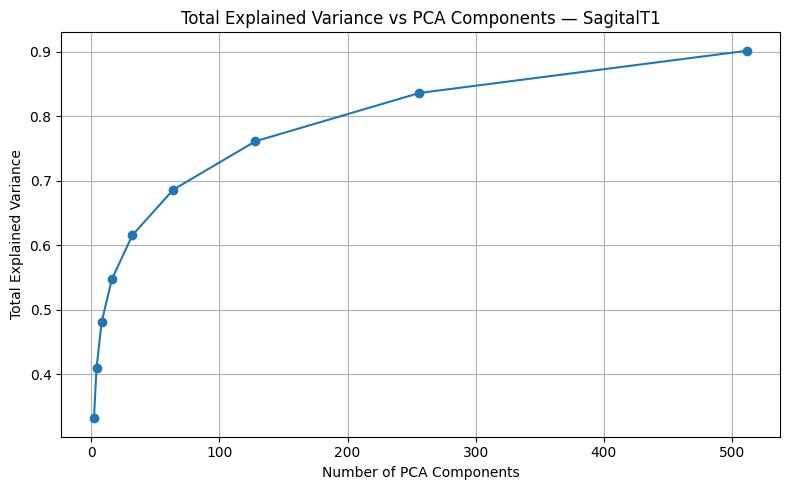

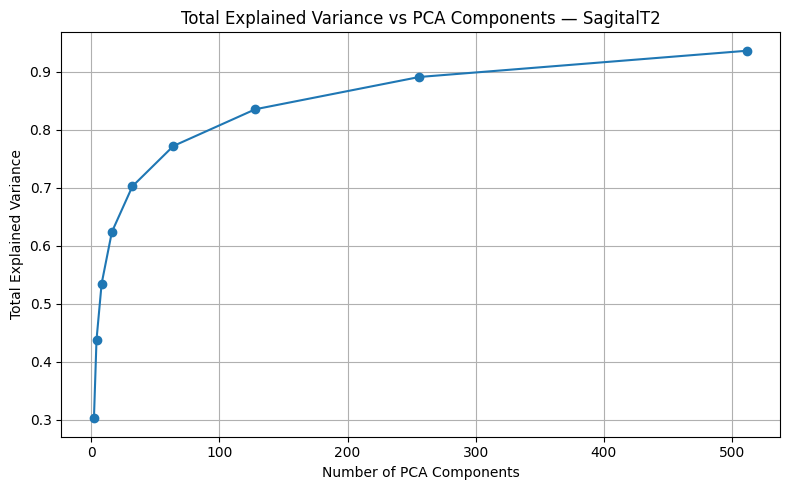

In [36]:
for i, name in enumerate(name_extension):
    variances = []
    
    for n in PCA_elements:
        pca_path = PROJECT_ROOT / "data" / "processed" / f"pca_{n}_variance_{name}.csv"
        pca = pd.read_csv(pca_path)
        total_var = pca["explained_variance"].sum()
        variances.append(total_var)
    
    # Plot for this plane
    plt.figure(figsize=(8, 5))
    plt.plot(PCA_elements, variances, marker='o')
    plt.title(f"Total Explained Variance vs PCA Components — {name}")
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Total Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
   

In [ ]:
for m in df_list:
    m.drop(columns=["matrix","flat","series_description"],inplace=True)

In [156]:
# load PCA CSV (assume project root is properly set)
i = 0
pca = pd.read_csv(PROJECT_ROOT / "data" / "processed" /f"pca_{256}_{name_extension[i]}.csv")
pca.columns = [f"pca_{i}" for i in range(pca.shape[1])]
df_with_pca = pd.concat([df_list[i].reset_index(drop=True), pca], axis=1)
#df_with_pca

In [157]:
from sklearn.model_selection import train_test_split

X = df_with_pca
y = X["severity"]
X = X.drop(columns=["severity"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)



In [158]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

preprocess = ColumnTransformer(
    transformers=[
        ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'), ["condition",	"level"]),
    ],
    remainder='passthrough' 
)


In [159]:
LRmodel = Pipeline([
    ('Preprocess', preprocess),
    ('Classifier', LogisticRegression(max_iter= 5000,penalty='l2',solver="lbfgs"))
])
KNNmodel = Pipeline([
    ('Preprocess', preprocess),
    ('Classifier', NearestNeighbors(n_neighbors=5, n_jobs=-1))
])
RFmodel = Pipeline([
    ('Preprocess', preprocess),
    ('Classifier', RandomForestClassifier(class_weight="balanced", max_depth= None, max_features="sqrt",min_samples_leaf=8,min_samples_split=10,n_estimators=400))
])

SVMmodel = Pipeline([
    ('Preprocess', preprocess), 
    ('Classifier', svm.SVC(kernel='rbf', C=1.0, gamma='scale'))  
])

from sklearn.metrics import classification_report

Current = SVMmodel.fit(X_train, y_train)

print("Train score:", Current.score(X_train, y_train))
print("Test score:", Current.score(X_test, y_test))



y_pred = Current.predict(X_train)

print("\n===== Training Classification Report =====")
print(classification_report(y_train, y_pred))

y_pred = Current.predict(X_test)
print("\n===== Testing Classification Report =====")
print(classification_report(y_test, y_pred))


Train score: 0.899232370543846
Test score: 0.8100442362737444

===== Training Classification Report =====
              precision    recall  f1-score   support

    Moderate       0.79      0.68      0.73      2922
 Normal/Mild       0.92      0.98      0.95     11005
      Severe       0.90      0.75      0.82      1445

    accuracy                           0.90     15372
   macro avg       0.87      0.80      0.83     15372
weighted avg       0.90      0.90      0.90     15372


===== Testing Classification Report =====
              precision    recall  f1-score   support

    Moderate       0.55      0.46      0.50       737
 Normal/Mild       0.87      0.95      0.91      2714
      Severe       0.77      0.51      0.61       392

    accuracy                           0.81      3843
   macro avg       0.73      0.64      0.67      3843
weighted avg       0.80      0.81      0.80      3843



In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

param_grid_LR = {
    "Classifier__C": [0.001,0.01, 0.1],
    "Classifier__penalty": ["l2"],
    "Classifier__solver": ["lbfgs", "saga"],
    "Classifier__max_iter": [100,500,1000, 2000, 4000,8000],
}

param_grid_RF = {
    "Classifier__n_estimators": [100, 200, 400],
    "Classifier__max_depth": [None, 10, 20, 30],
    "Classifier__min_samples_split": [2, 5, 10],
    "Classifier__min_samples_leaf": [1, 2, 4],
    "Classifier__max_features": ["sqrt", "log2"],
    "Classifier__class_weight": [None, "balanced"]
}
param_grid_SVM = {
    'Classifier__C': [0.1, 1, 10, 100, 1000],
    'Classifier__gamma': ['scale', 'auto', 0.001,0.003, 0.01,0.03, 0.1],
    'Classifier__probability': [True],
    'Classifier__class_weight': [None, 'balanced']
}


grid = GridSearchCV(
    estimator=SVMmodel,
    param_grid=param_grid_SVM,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)

grid.fit(X, y)

In [53]:
print("Best parameters:", grid.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

Best parameters LR: {'Classifier__C': 0.01, 'Classifier__max_iter': 10000, 'Classifier__penalty': 'l2', 'Classifier__solver': 'lbfgs'}
Best parameters: RF: 'Classifier__class_weight': 'balanced', 'Classifier__max_depth': None, 'Classifier__max_features': 'sqrt', 'Classifier__min_samples_leaf': 4, 'Classifier__min_samples_split': 10, 'Classifier__n_estimators': 400


===== Training Classification Report =====
              precision    recall  f1-score   support

    Moderate       0.65      0.52      0.57      2901
 Normal/Mild       0.90      0.95      0.92     10985
      Severe       0.76      0.74      0.75      1486

    accuracy                           0.84     15372
   macro avg       0.77      0.73      0.75     15372
weighted avg       0.84      0.84      0.84     15372


===== Testing Classification Report =====
              precision    recall  f1-score   support

    Moderate       0.53      0.40      0.45       758
 Normal/Mild       0.88      0.93      0.90      2734
      Severe       0.66      0.68      0.67       351

    accuracy                           0.80      3843
   macro avg       0.69      0.67      0.67      3843
weighted avg       0.79      0.80      0.79      3843



array([[0.02849488, 0.96582852, 0.0056766 ],
       [0.0836434 , 0.91489842, 0.00145817],
       [0.04086861, 0.95574461, 0.00338677],
       ...,
       [0.15097189, 0.84244218, 0.00658593],
       [0.18466219, 0.80132909, 0.01400872],
       [0.26308352, 0.70449113, 0.03242535]], shape=(9729, 3))

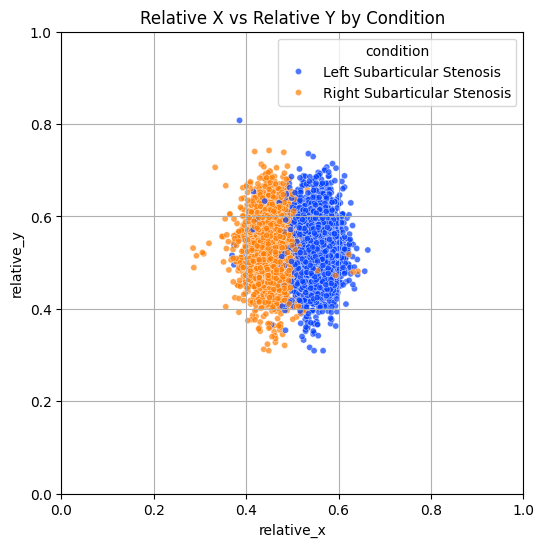

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_with_pca,
    x="relative_x",
    y="relative_y",
    hue="condition",
    palette="bright",
    s = 20,
    alpha=0.7
)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Relative X vs Relative Y by Condition")
plt.grid(True)
plt.show()


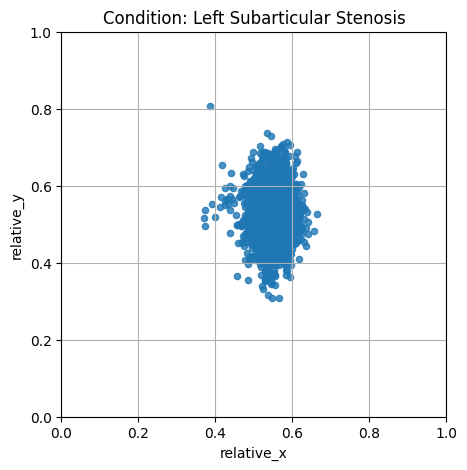

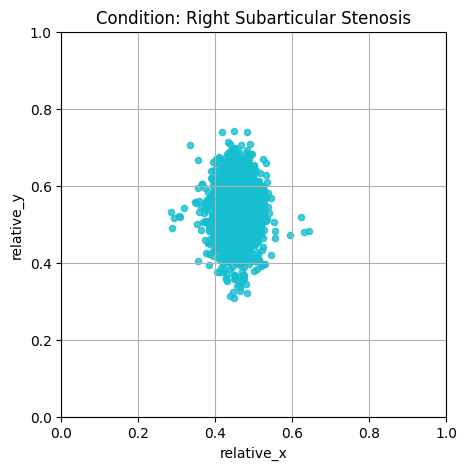

In [ ]:
conditions = df_with_pca["condition"].unique()

# one unique color per plot
colors = cm.tab10(np.linspace(0, 1, len(conditions)))

for cond, color in zip(conditions, colors):
    subset = df_with_pca[df_with_pca["condition"] == cond]

    plt.figure(figsize=(6, 5))
    plt.scatter(
        subset["relative_x"],
        subset["relative_y"],
        s=20,
        alpha=0.8,
        color=color
    )

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel("relative_x")
    plt.ylabel("relative_y")
    plt.title(f"Condition: {cond}")
    plt.grid(True)
    plt.show()

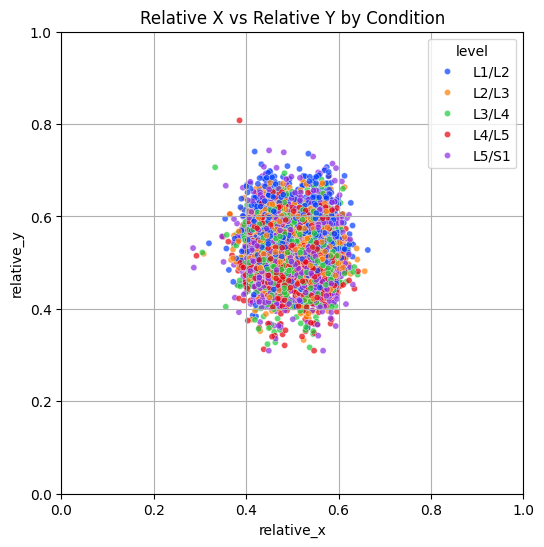

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_with_pca,
    x="relative_x",
    y="relative_y",
    hue="level",
    palette="bright",
    s = 20,
    alpha=0.7
)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Relative X vs Relative Y by Condition")
plt.grid(True)
plt.show()


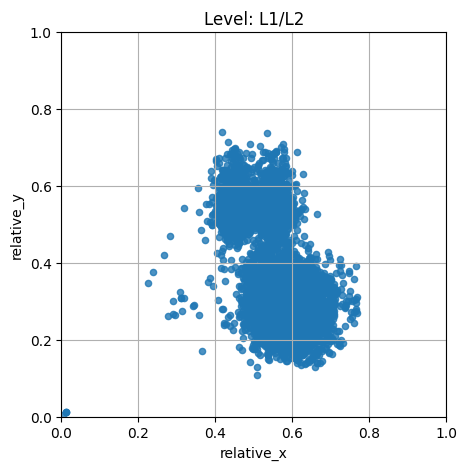

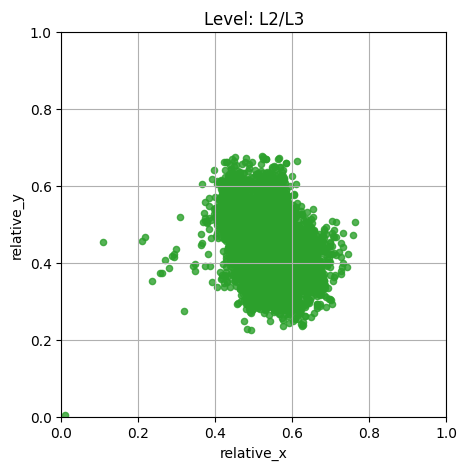

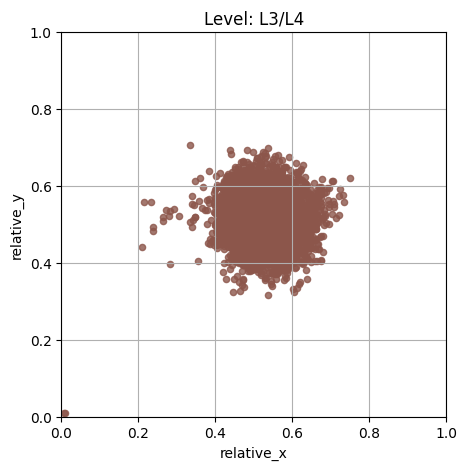

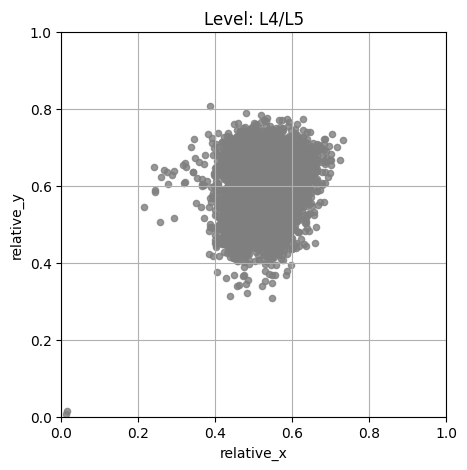

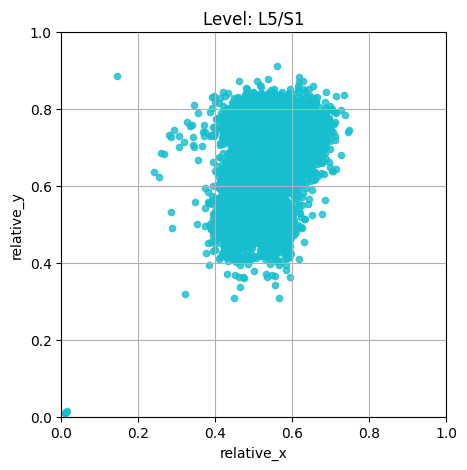

In [ ]:
conditions = df_clean["level"].unique()

# one unique color per plot
colors = cm.tab10(np.linspace(0, 1, len(conditions)))

for cond, color in zip(conditions, colors):
    subset = df_clean[df_clean["level"] == cond]

    plt.figure(figsize=(6, 5))
    plt.scatter(
        subset["relative_x"],
        subset["relative_y"],
        s=20,
        alpha=0.8,
        color=color
    )

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlabel("relative_x")
    plt.ylabel("relative_y")
    plt.title(f"Level: {cond}")
    plt.grid(True)
    plt.show()

In [ ]:
# We will use only CSV columns (no images):
# - Numeric: relative_x, relative_y, instance_number
# - Categorical: side, level
# - Label: condition
required_cols = ["relative_x", "relative_y", "instance_number", "side", "level", "condition"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in CSV: {missing}")

use_df = df[required_cols].copy()
before = len(use_df)
use_df = use_df.dropna(subset=required_cols)
after = len(use_df)
print(f"[INFO] Dropped {before - after} rows with NA in required fields.")

# Encode textual labels to integer classes
le = LabelEncoder()
y = le.fit_transform(use_df["condition"].astype(str).values)
X = use_df.drop(columns=["condition"])

print("[INFO] Classes:", list(le.classes_))


KeyError: "Missing required columns in CSV: ['instance_number', 'side']"

In [ ]:
# First split: train vs (val+test)
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
# Second split: val vs test (from the remaining 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=42
)

print(f"[INFO] Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


[INFO] Shapes -> Train: (41114, 5), Val: (8810, 5), Test: (8811, 5)


In [ ]:
numeric_features = ["relative_x", "relative_y", "instance_number"]
categorical_features = ["side", "level"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


In [ ]:
# Multinomial Logistic Regression
clf = LogisticRegression(
    multi_class="multinomial",
    solver="saga",                 # good for multinomial + one-hot
    max_iter=5000,
    class_weight="balanced",       # mitigates class imbalance
    random_state=42,
    verbose=0,
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("logreg", clf),
])

# Fit
model.fit(X_train, y_train)


c:\Users\mmich\anaconda3\envs\iteso-ML\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('preprocess', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



[VAL] Accuracy: 0.7365
[VAL] Classification report:
                                  precision    recall  f1-score   support

 Left Neural Foraminal Narrowing       0.97      0.99      0.98      1484
      Left Subarticular Stenosis       0.67      0.73      0.70      1441
Right Neural Foraminal Narrowing       0.42      0.68      0.52      1484
     Right Subarticular Stenosis       0.84      0.92      0.88      1442
           Spinal Canal Stenosis       0.95      0.56      0.70      2959

                        accuracy                           0.74      8810
                       macro avg       0.77      0.77      0.75      8810
                    weighted avg       0.80      0.74      0.74      8810

[VAL] Confusion matrix:
[[1463    0    0    0   21]
 [   0 1048  353   34    6]
 [   0  268 1011  143   62]
 [   0   31   87 1324    0]
 [  47  225  970   74 1643]]


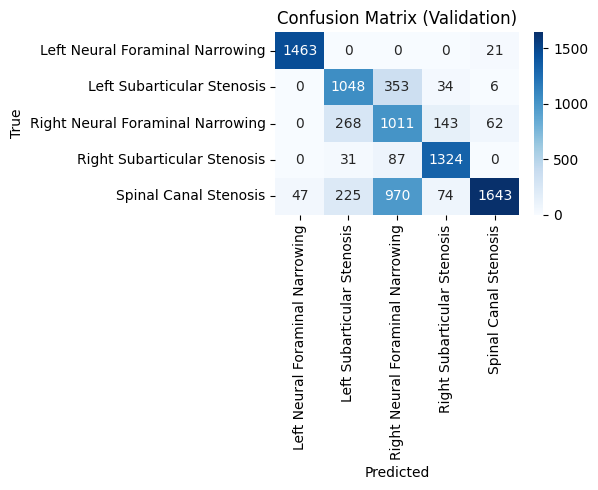


[TEST] Accuracy: 0.7554
[TEST] Classification report:
                                  precision    recall  f1-score   support

 Left Neural Foraminal Narrowing       0.97      0.99      0.98      1485
      Left Subarticular Stenosis       0.68      0.77      0.72      1441
Right Neural Foraminal Narrowing       0.45      0.72      0.56      1484
     Right Subarticular Stenosis       0.86      0.92      0.89      1442
           Spinal Canal Stenosis       0.95      0.57      0.71      2959

                        accuracy                           0.76      8811
                       macro avg       0.78      0.79      0.77      8811
                    weighted avg       0.81      0.76      0.76      8811

[TEST] Confusion matrix:
[[1472    0    0    0   13]
 [   0 1106  290   30   15]
 [   0  245 1064  118   57]
 [   0   41   78 1323    0]
 [  47  241  913   67 1691]]


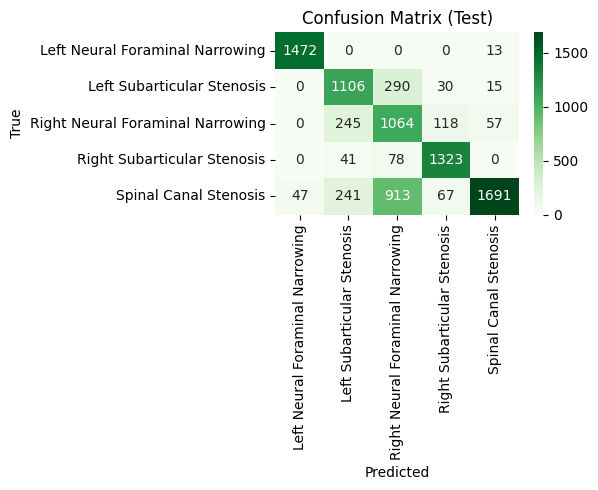

In [ ]:
# Validation
y_val_pred = model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print("\n[VAL] Accuracy:", f"{val_acc:.4f}")
print("[VAL] Classification report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_, zero_division=0))
print("[VAL] Confusion matrix:")
cm_val = confusion_matrix(y_val, y_val_pred)
print(cm_val)

# Plot confusion matrix (val)
plt.figure(figsize=(6,5))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Test
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("\n[TEST] Accuracy:", f"{test_acc:.4f}")
print("[TEST] Classification report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_, zero_division=0))
print("[TEST] Confusion matrix:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)

# Plot confusion matrix (test)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Greens",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
# Optional: persist the trained pipeline + label encoder
SAVE_MODEL = False
MODEL_OUT = "logreg_pipeline.joblib"

if SAVE_MODEL:
    import joblib
    joblib.dump({"pipeline": model, "label_encoder": le, "classes_": le.classes_}, MODEL_OUT)
    print(f"[SAVED] {MODEL_OUT}")
